# [cutoffs_and_troughs](https://github.com/ahijevyc/cutoffs_and_troughs) repo

In [2]:
import logging
import os
import pdb
import warnings
from collections.abc import Iterable
from functools import partial
from pathlib import Path

import cartopy
import matplotlib.animation
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML
from utils import fmt, getobs, haversine, na_values, tissot

sns.set_theme(style="whitegrid")
logging.basicConfig(level=logging.WARNING, format="%(asctime)s %(message)s", force=True)

In [3]:
Lupo_cases_Table2 = (
    "20160123",
    "20160427",
    "20170315",
    "20180310",
    "20190203",
    "20190529",
    "20191031",
    "20200411",
    "20200902",
    "20200908",
)


loc2color = {"any": "C0", "CONUS": "C1", "Lupo2023": "C2"}


def get_location(df: pd.DataFrame) -> pd.Series:
    """
    Return descriptive location for each row in df
    given lat/lon, time, and ID
    """
    location = pd.Series("any", index=df.index)
    location[
        (df["LAT(N)"] >= lat0)
        & (df["LAT(N)"] < lat1)
        & (df["LON(E)"] >= lon0)
        & (df["LON(E)"] < lon1)
    ] = "CONUS"
    ee = (df["ITIME"] == 2019102206) & (df["ID"] == 32379)
    ee |= (df["ITIME"] == 2019112306) & (df["ID"] == 33027)
    ee |= (df["ITIME"] == 2019121900) & (df["ID"] == 33453)
    ee |= (df["ITIME"] == 2020020806) & (df["ID"] == 34354)
    ee |= (df["ITIME"] == 2020022900) & (df["ID"] == 34916)
    ee |= (df["ITIME"] == 2020040512) & (df["ID"] == 35563)
    ee |= (df["ITIME"] == 2020040812) & (df["ID"] == 35563)
    ee |= (df["ITIME"] == 2020051512) & (df["ID"] == 36483)
    ee |= (df["ITIME"] == 2020090600) & (df["ID"] == 38671)
    ee |= (df["ITIME"] == 2020112406) & (df["ID"] == 40236)
    ee |= (df["ITIME"] == 2021031318) & (df["ID"] == 42385)
    ee |= (df["ITIME"] == 2021042706) & (df["ID"] == 43351)
    ee |= (df["ITIME"] == 2021123006) & (df["ID"] == 48354)
    ee |= (df["ITIME"] == 2022041006) & (df["ID"] == 50591)
    ee |= (df["ITIME"] == 2022050112) & (df["ID"] == 51124)
    ee |= (df["ITIME"] == 2022061018) & (df["ID"] == 51941)
    location[ee] = "Lupo2023"
    return location


def get_contains_zmin(df: pd.DataFrame) -> pd.Series:
    """Return "contains_zmin" column"""
    lloc = df[["LON(E)", "LAT(N)"]]
    zloc = df[["ZLON(E)", "ZLAT(N)"]]
    contains_zmin = pd.Series(haversine(lloc, zloc) < df["Ro(km)"], index=df.index)
    return contains_zmin

In [4]:
casedir = Path("/glade/campaign/mmm/parc/mwong/ufs-mrw")
workdir = Path(os.getenv("SCRATCH")) / "ks21_tmp"

# set extent
lon0 = 360 - 127
lon1 = 360 - 68
lat0 = 23
lat1 = 50

itime = "20200408T12"
itime = pd.to_datetime(itime)

logging.info(f"itime={itime}")

isensemble = True
# Choose a forecast length (24, 48, 72, or 240 work)
forecast_length = 240

datepos = 0
cases = sorted(casedir.glob(f"[12]?????????.F{forecast_length:03d}.C768"))
if isensemble:
    forecast_length = (pd.to_datetime("20200413T12") - itime) / pd.to_timedelta(1, "hour")
    forecast_length = int(forecast_length)
    cases = sorted(casedir.glob(f"E[12]?????????.p??.F{forecast_length:03d}.C768"))
    datepos = 1


itimes = [pd.to_datetime(c.name[datepos : datepos + 10], format=fmt) for c in cases]
print(f"found {len(itimes)} itimes with {forecast_length}-h forecasts in casedir {casedir}")


pd.Series(itimes, name="itime")

found 20 itimes with 120-h forecasts in casedir /glade/campaign/mmm/parc/mwong/ufs-mrw


0    2020-04-08 12:00:00
1    2020-04-08 12:00:00
2    2020-04-08 12:00:00
3    2020-04-08 12:00:00
4    2020-04-08 12:00:00
5    2020-04-08 12:00:00
6    2020-04-08 12:00:00
7    2020-04-08 12:00:00
8    2020-04-08 12:00:00
9    2020-04-08 12:00:00
10   2020-04-08 12:00:00
11   2020-04-08 12:00:00
12   2020-04-08 12:00:00
13   2020-04-08 12:00:00
14   2020-04-08 12:00:00
15   2020-04-08 12:00:00
16   2020-04-08 12:00:00
17   2020-04-08 12:00:00
18   2020-04-08 12:00:00
19   2020-04-08 12:00:00
Name: itime, dtype: datetime64[ns]

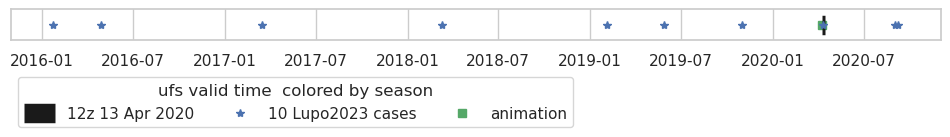

In [5]:
fig, ax = plt.subplots(figsize=(12, 0.4))
ax.plot()
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
lw = 14
for t in set(itimes):
    color = "k"
    vtime = t + forecast_length * pd.Timedelta(hours=1)
    if vtime.month >= 5 and vtime.month <= 9:
        color = "C1"  # element in axes color prop cycler
    ax.hlines(0, t, vtime, label=vtime.strftime("%-Hz %-d %b %Y"), color=color, lw=lw)
ax.plot(
    [pd.to_datetime(d) for d in Lupo_cases_Table2],
    [0.00] * len(Lupo_cases_Table2),
    "*",
    label=f"{len(Lupo_cases_Table2)} Lupo2023 cases",
)
ax.plot(
    itime,
    0.00,
    "s",
    label="animation",
    zorder=0,
    color="C2",
)
ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.0, -0.96),
    title="ufs valid time  colored by season",
    ncol=5,
)

In [8]:
warnings.filterwarnings("ignore", category=UserWarning, module="cartopy")

ncolors = len(plt.rcParams["axes.prop_cycle"])

def label_id(ax: plt.axes, df: pd.DataFrame, **kwargs) -> None:
    markers = [">", "<", "P", "D", "^", "v", "*", "s"]

    for i, row in df.iterrows():
        x = row["LON(E)"]
        y = row["LAT(N)"]
        color = row["color"]
        ax.plot(
            row["ZLON(E)"],
            row["ZLAT(N)"],
            "o",
            transform=cartopy.crs.PlateCarree(),
            color=color,
            markerfacecolor="none",
            label="Zmin",
        )

        visible = lon0 <= (x + 360) % 360 < lon1
        visible &= lat0 <= y < lat1

        if np.isnan(row.ID):
            logging.info(f"no ID {row.name}")
            continue
        if not visible:
            logging.info(f"{row.ID} not visible")
            continue
        if "VLon(E)" not in row or np.isnan(row["VLon(E)"]):
            logging.info(f"no VLon(E) {row.ID}")
            continue

        vx = row["VLon(E)"]
        vy = row["VLat(N)"]
        # transform=Geodetic so it follows great circle, not straight line in projection of axes
        logging.info(f"marker and line {vx,x} {vy, y}")
        marker = markers[int(row["ID"] % len(markers))]
        ax.plot(
            [vx, x],
            [vy, y],
            marker=marker,
            color="k",
            markeredgecolor="none",
            alpha = 0.5,
            label=int(row["ID"]),
            transform=cartopy.crs.Geodetic(),
        )
    return


text_kw = dict(
    fontsize="xx-small",
    horizontalalignment="center",
    verticalalignment="center",
    transform=cartopy.crs.PlateCarree(),
    clip_on=True,
)


def animate(valid_time, itime, workdir: Path, forecast_length: int, ids:Iterable = None):
    print(valid_time, end="")
    obs_path = valid_time.strftime(
        "/glade/u/home/klupo/work_new/postdoc/kasugaEA21/version9/HGT_500mb/"
        f"gfs.0p25.%Y%m%d%H.f000.track"
    )
    obs = getobs(valid_time)
    obs["color"] = "k"
    obs["contains_zmin"] = get_contains_zmin(obs)
    if ids is not None:
        obs = obs[obs.ID.isin(ids)]

    plt.cla()
    # ax.set_global()
    ax.set_extent((lon0, lon1, lat0, lat1))
    coastlines = ax.coastlines(lw=0.25)
    gridlines = ax.gridlines(lw=0.25, alpha=0.5)
    ax.add_feature(cartopy.feature.STATES, lw=0.2, alpha=0.5)

    alpha = 0.8
    fhr = (valid_time - itime) / pd.Timedelta(hours=1)
    workdirs = [workdir / f"{itime.strftime(fmt)}.F{forecast_length:03d}.C768"]
    if isensemble:  # all the members
        workdirs = workdir.glob(f"E{itime.strftime(fmt)}.p??.*")
        alpha = 0.2

    analysis_blob = tissot(ax, obs, alpha=0.4)
    for workdir in workdirs:
        ifile = workdir / f"diag_TroughsCutoffs.{itime.strftime(fmt)}.f{fhr:03.0f}.track"
        print(".", end="")
        df = pd.read_csv(
            ifile,
            header=0,
            sep=r"\s+",
            na_values=na_values,
        )
        df["location"] = get_location(df)
        df["color"] = df["location"].map(loc2color)
        df["contains_zmin"] = get_contains_zmin(df)

        if ids is not None:
            df = df[df.ID.isin(ids)]
        ax.set_title(f"{valid_time} f{fhr:03.0f}")
        tissot(ax, df, alpha=alpha)
        text_ids = label_id(
            ax,
            df,
            **text_kw,
        )
    # don't show duplicates
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # ax.legend(by_label.values(), by_label.keys())

    return

func = partial(animate, itime=itime, workdir=workdir, forecast_length=forecast_length)

<li>grey ellipse = analyzed feature at valid time (2020-04-10 18 UTC).
<li>green = forecast feature with big zonal forecast error that we are focusing on
<li>orange = other forecast feature in CONUS area not matched to the feature that we are focusing on
<li>blue = other forecast feature outside of CONUS area
<li>matching black symbols = forecast features sharing the same connection to an analyzed feature. A straight colored line connects them to analyzed feature.
<li>colored circles = location of geopotential height minimum inside the feature indicating a cutoff low, as opposed to a trough.


2020-04-08 12:00:00....................2020-04-08 12:00:00....................2020-04-09 12:00:00....................2020-04-10 12:00:00....................2020-04-11 12:00:00....................2020-04-12 12:00:00....................2020-04-13 12:00:00....................

2020-04-08 12:00:00....................

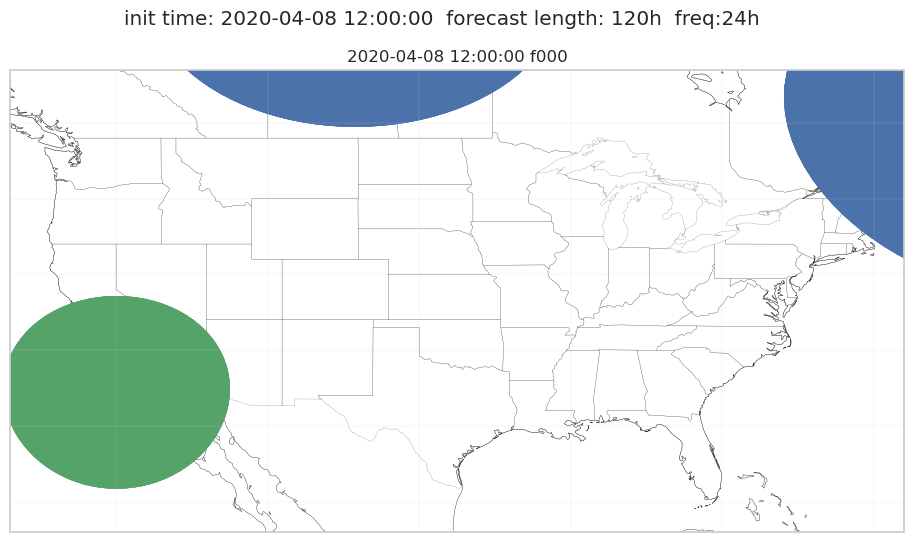

In [9]:
# Choose one of the initializations of itimes.
fig, ax = plt.subplots(
    figsize=(12, 6),
    subplot_kw={"projection": cartopy.crs.PlateCarree()},
)
freq = "24h"
suptitle = f"init time: {itime}  forecast length: {forecast_length:03d}h  freq:{freq}"
fig.suptitle(suptitle)
valid_times = pd.date_range(start=itime, end=itime + pd.Timedelta(hours=forecast_length), freq=freq)
ani = matplotlib.animation.FuncAnimation(fig, func, frames=valid_times)

HTML(ani.to_jshtml())

2020-04-12 12:00:00..................../glade/derecho/scratch/ahijevyc/cutoffs_and_troughs/notebooks/20200408.2020041212.isensembleTrue.png


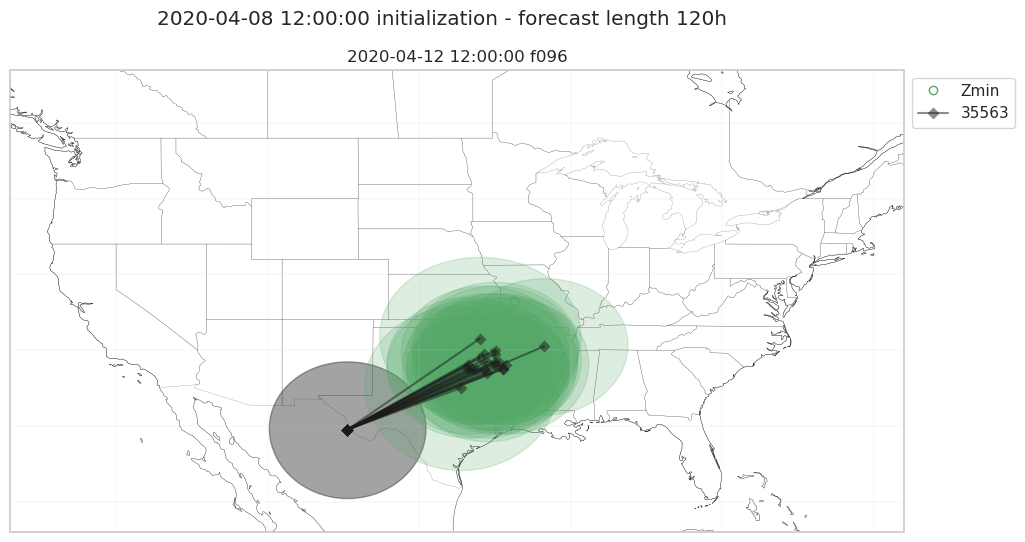

In [10]:
fig, ax = plt.subplots(
    figsize=(12, 6),
    subplot_kw={"projection": cartopy.crs.PlateCarree()},
)
suptitle = f"{itime} initialization - forecast length {forecast_length:03d}h"
fig.suptitle(suptitle)
valid_time = pd.to_datetime("20200412T12")
func(valid_time, ids = [35563])
ofile = (
    f'{itime.strftime("%Y%m%d")}.{valid_time.strftime("%Y%m%d%H")}.isensemble{isensemble}.png'
)
# don't show duplicates
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1, 1), loc="upper left")
fig.savefig(ofile)
print(os.path.realpath(ofile))

## Analyze all track files, regardless of forecast length

In [11]:
files = workdir.glob("[12]?????????.F???.C768/diag_TroughsCutoffs.??????????.f???.track")
if isensemble:
    files = workdir.glob("E[12]?????????.p??.*/diag_TroughsCutoffs.??????????.f???.track")
files = list(files)  # convert generator to list
logging.warning(f"{len(files)} files")

df = pd.concat(
    [
        pd.read_csv(
            f,
            header=0,
            sep=r"\s+",
            na_values=na_values,
        )
        for f in files
    ],
    ignore_index=True,
)

df["location"] = get_location(df)
df["color"] = df["location"].map(loc2color)
df["contains_zmin"] = get_contains_zmin(df)
df["FHOUR"] = df["FHOUR"].str.lstrip("f").astype(float)
df["ITIME"] = pd.to_datetime(df["ITIME"], format="%Y%m%d%H")
df["FDAY"] = (df["FHOUR"] / 24).astype(int)
df["feature"] = "trough"
df.loc[df["contains_zmin"], "feature"] = "cutoff low"
# Divide NH zonal error into terciles (3 equal-sized groups based on value)
df["FERRX"] = pd.qcut(df["FERRX(km)"], 3, labels=["low", "med", "high"])
# df = df[df["FHOUR"] <= 96]
df.color.unique()

2024-11-21 10:24:33,661 1080 files


array(['C0', 'C2', 'C1'], dtype=object)

In [21]:
df["location"].unique()

array(['any', 'CONUS', 'Lupo2023'], dtype=object)

In [22]:
df["So(m/100km)"].describe()

count    61459.000000
mean        18.334215
std          7.169960
min         10.000000
25%         13.410000
50%         16.950000
75%         21.375000
max        128.100000
Name: So(m/100km), dtype: float64

In [23]:
def fix_axes(fp):
    axes = np.atleast_1d(fp.axes)
    lim = (-900, 900)
    for ax in axes.ravel():
        ax.grid(alpha=0.5)
        if ax.get_xlabel().endswith("(N)"):
            ax.set_xlim((-90, 90))
        if ax.get_ylabel().endswith("(N)"):
            ax.set_ylim((-90, 90))
        if ax.get_xlabel().endswith("(E)"):
            ax.set_xlim((0, 360))
        if ax.get_ylabel().endswith("(E)"):
            ax.set_ylim((0, 360))
        if ax.get_xlabel().endswith("(km)"):
            ax.set_xlim(*lim)
        if ax.get_ylabel().endswith("(km)"):
            ax.set_ylim(*lim)
        if ax.get_xlabel() == "LON(E)" and ax.get_ylabel() == "LAT(N)":
            geo_axes = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=180))
            position = ax.get_position()
            geo_axes.set_position(position)
            extent = (*ax.get_xlim(), *ax.get_ylim())
            geo_axes.set_extent(extent, crs=cartopy.crs.PlateCarree())
            geo_axes.coastlines(lw=0.5)
            geo_axes.patch.set_visible(False)
            geo_axes.set_aspect("auto")
    return

### Analysis and up to 240-h forecast tracks of a cutoff low over the United States valid during 1800 UTC 7 Sep–1800 UTC 13 Sep 2020

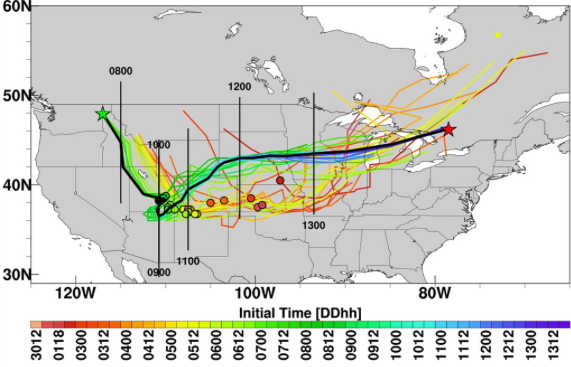

Citation: Weather and Forecasting 38, 10; 10.1175/WAF-D-22-0224.1

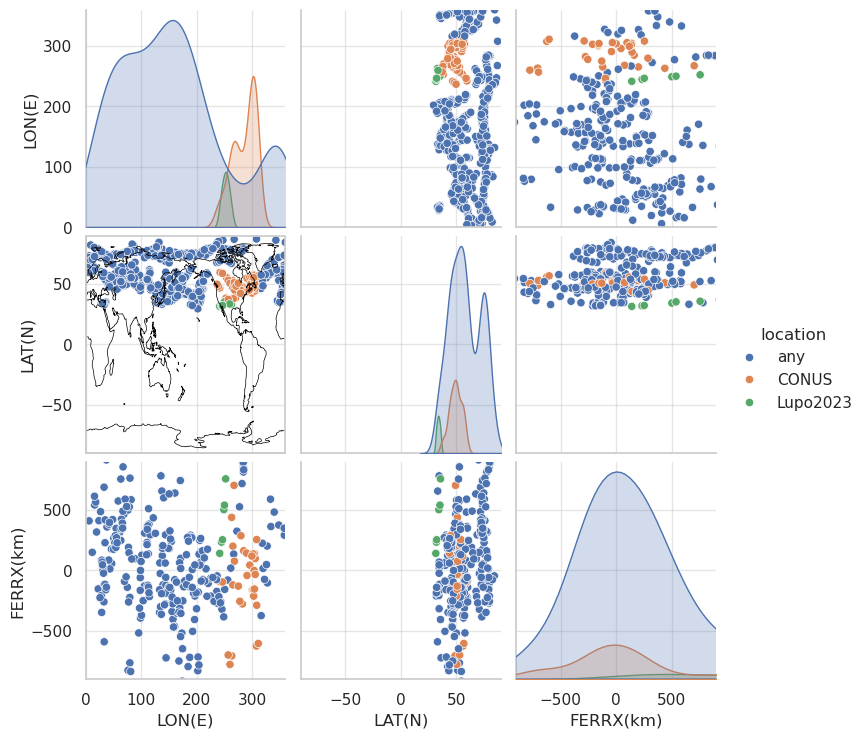

In [24]:
fp = sns.pairplot(
    df[(df["ITIME"] == itime) & (df["FHOUR"] >= 72) & (df["LAT(N)"] >= 0)],
    vars=["LON(E)", "LAT(N)", "FERRX(km)"],
    hue="location",
)
fix_axes(fp)

In [25]:
df[(df["ITIME"] == itime) & (df["FHOUR"] >= 72)].groupby("location").describe()["FERRX(km)"]

count        mean      min      25%     50%        75%      max  \
location                                                                    
CONUS      34.0  -19.791176  -777.52 -199.350  -37.59   142.1625  1002.23   
Lupo2023   11.0  909.277273   141.10  378.075  757.28  1362.5550  1943.40   
any       539.0  131.830019 -3395.55 -207.575   65.96   391.4900  3201.50   

                 std  
location              
CONUS     413.320485  
Lupo2023  633.468100  
any       667.527738

In [26]:
df[df["FHOUR"] >= 72].groupby("location").describe()["FERRX(km)"]

count        mean      min     25%     50%      75%       max  \
location                                                                    
CONUS      1078.0   45.242505 -3460.12 -222.37   38.89  292.125   3730.74   
Lupo2023    209.0  579.221962  -428.73  294.10  502.58  766.050   2045.63   
any       12043.0  -16.808891 -5860.40 -322.22    0.00  297.450  10834.62   

                 std  
location              
CONUS     625.737076  
Lupo2023  475.057814  
any       769.174900

In [27]:
df[df["FHOUR"] >= 72].groupby("location").describe()["FERRX(km)"]

count        mean      min     25%     50%      75%       max  \
location                                                                    
CONUS      1078.0   45.242505 -3460.12 -222.37   38.89  292.125   3730.74   
Lupo2023    209.0  579.221962  -428.73  294.10  502.58  766.050   2045.63   
any       12043.0  -16.808891 -5860.40 -322.22    0.00  297.450  10834.62   

                 std  
location              
CONUS     625.737076  
Lupo2023  475.057814  
any       769.174900

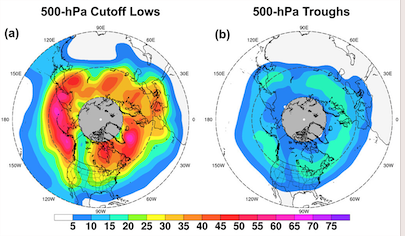

Citation: Weather and Forecasting 38, 10; 10.1175/WAF-D-22-0224.1

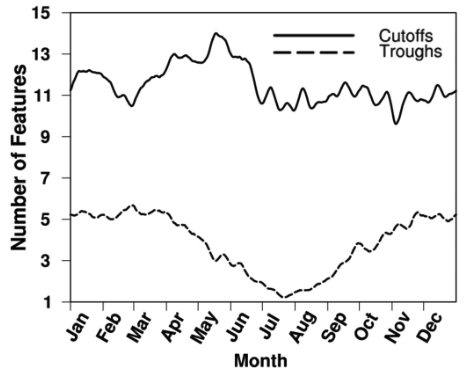

https://journals.ametsoc.org/view/journals/wefo/38/10/full-WAF-D-22-0224.1-f7.jpg

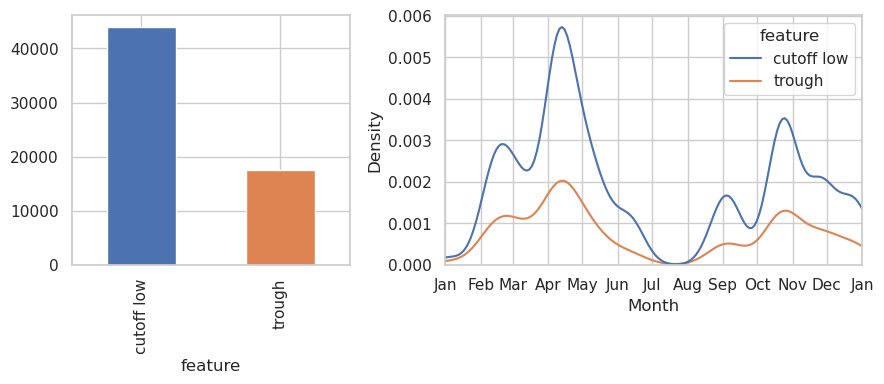

In [28]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

df["dayofyear"] = df["ITIME"].dt.dayofyear
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), width_ratios=[2, 3])
df["feature"].value_counts().plot(kind="bar", color=["C0", "C1"], ax=axes[0])
ax = axes[1]
ax = sns.kdeplot(df, x="dayofyear", hue="feature", ax=ax)
ax.set_xlabel("Month")
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_xlim((0, 365))
plt.tight_layout()

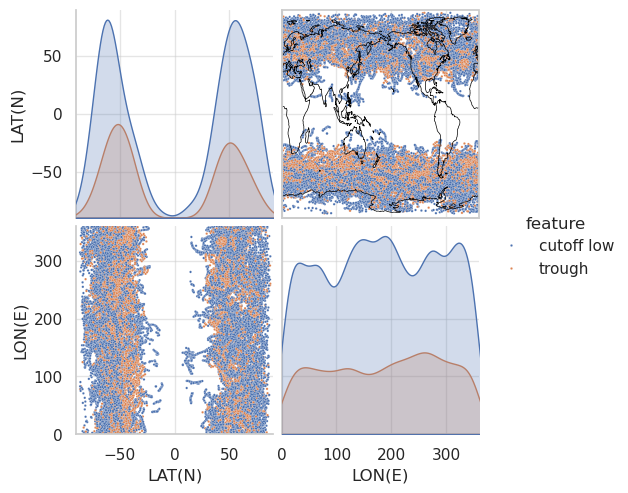

In [29]:
fp = sns.pairplot(
    df[(df["FHOUR"] >= 72)],
    vars=["LAT(N)", "LON(E)"],
    plot_kws={"s": 3},
    hue="feature",
)
fix_axes(fp)

## Divide NH zonal error into terciles (3 equal-sized groups based on value)

- high zonal error (progressive) most common over CONUS
- has greater meridional background slope

isForecast
False    Axes(0.125,0.11;0.775x0.77)
True     Axes(0.125,0.11;0.775x0.77)
Name: Ro(km), dtype: object

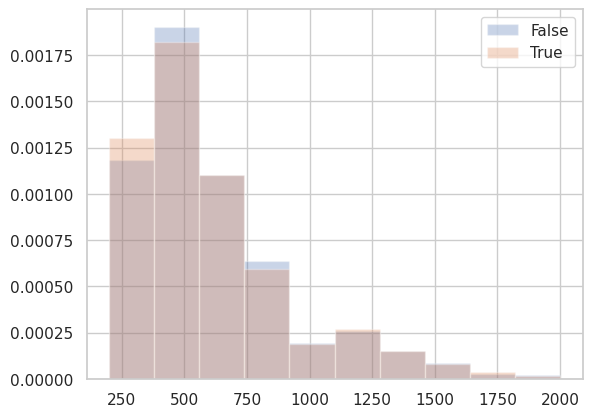

In [30]:
df["isForecast"] = df["FHOUR"] > 0
df.groupby("isForecast")["Ro(km)"].hist(density=True, alpha=0.3, legend=True)

isForecast
False    Axes(0.125,0.11;0.775x0.77)
True     Axes(0.125,0.11;0.775x0.77)
Name: T500(K), dtype: object

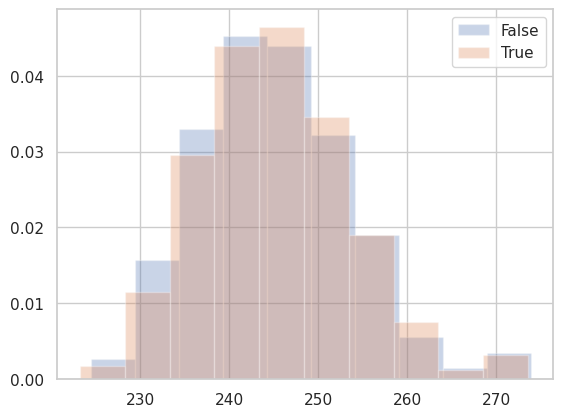

In [31]:
df.groupby("isForecast")["T500(K)"].hist(density=True, alpha=0.3, legend=True)

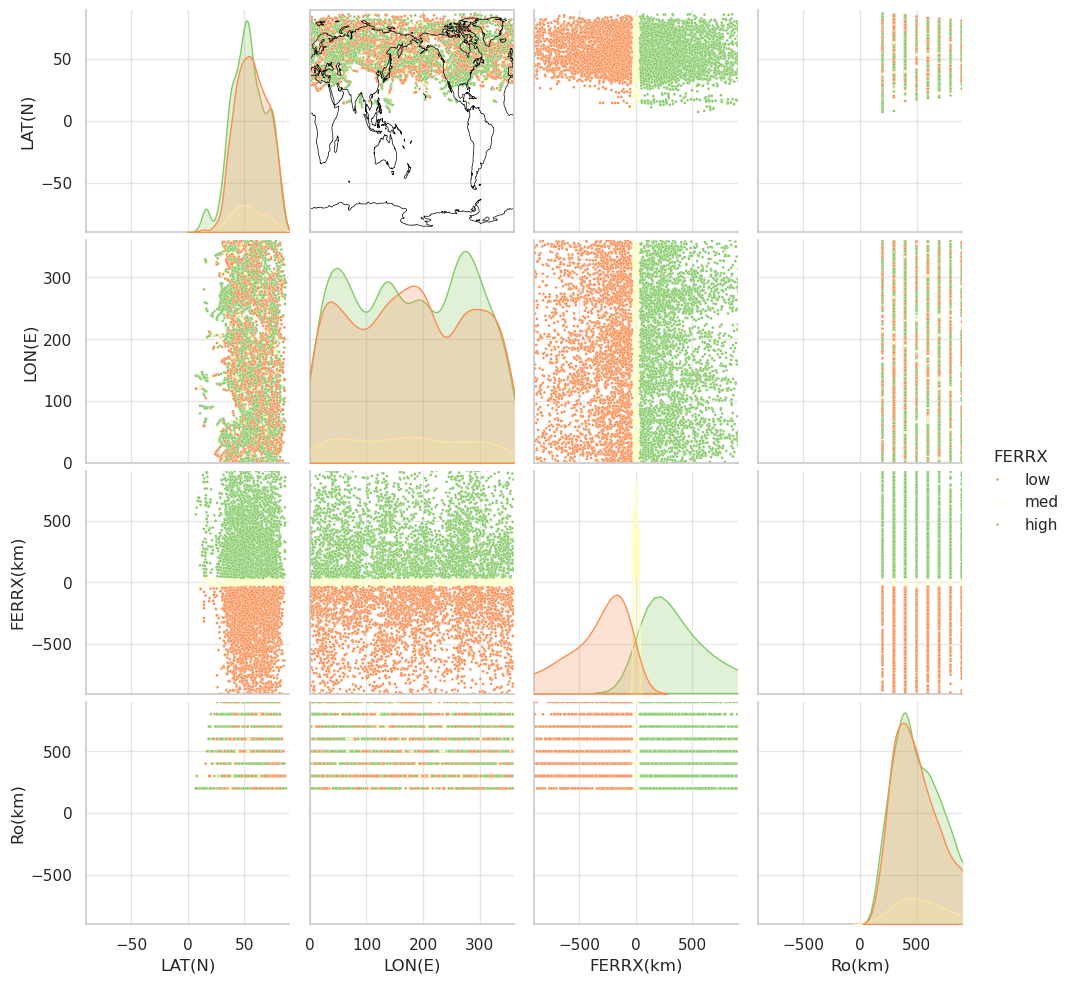

In [32]:
fp = sns.pairplot(
    df[
        (df["FHOUR"] >= 72)
        & (df["LAT(N)"] >= 0)
        # & (df["LAT(N)"] >= lat0)
        # & (df["LAT(N)"] < lat1)
        # & (df["LON(E)"] >= lon0)
        # & (df["LON(E)"] < lon1)
    ],
    vars=[
        "LAT(N)",
        "LON(E)",
        "FERRX(km)",
        #        "FERRY(km)",
        #        "BGo-lon(m/100km)",
        #        "BGo-lat(m/100km)",
        "Ro(km)",
    ],
    plot_kws={"s": 4},
    hue="FERRX",
    palette="RdYlGn",
)
fix_axes(fp)

In [33]:
df[df["FHOUR"] >= 72].describe().loc["mean"]

ITIME               2021-01-01 03:29:39.059456512
FHOUR                                  152.313691
ID                                   41244.663439
So(m/100km)                             18.233408
LAT(N)                                   1.557685
LON(E)                                 183.501629
SoFlag                                  -0.428626
Ro(km)                                 590.010989
SR                                        0.97651
BGo(m/100km)                            16.368753
BGo-lat(m/100km)                         1.779235
BGo-lon(m/100km)                         0.794555
ZMIN(m)                               5186.784187
ZLAT(N)                                  3.466459
ZLON(E)                                182.360647
Z850(m)                               1294.731145
Z500(m)                               5281.761957
Z200(m)                              11413.249176
T850(K)                                267.295293
T500(K)                                244.955451


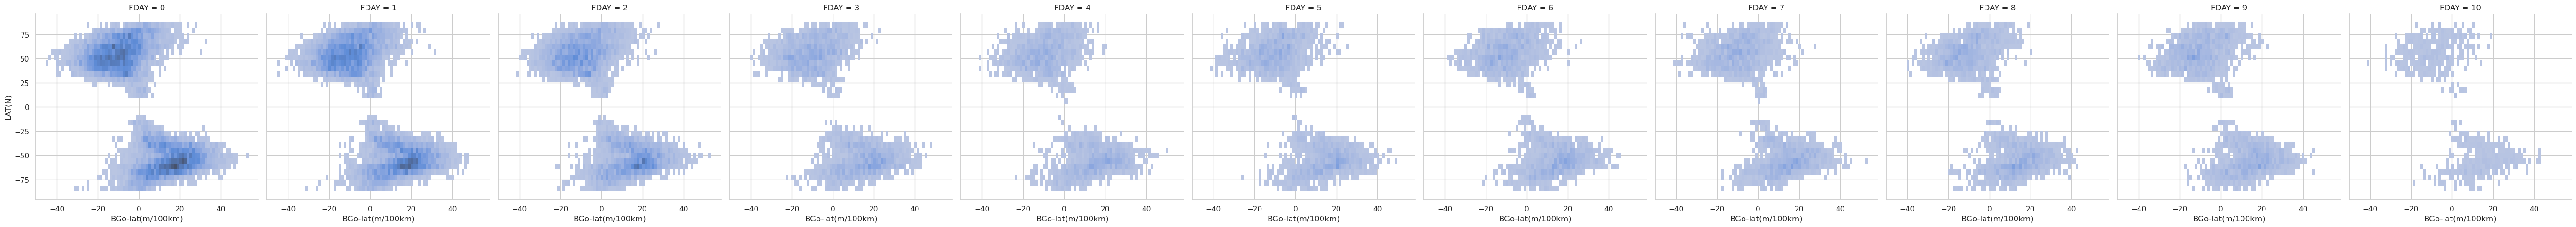

In [34]:
sns.displot(data=df, x="BGo-lat(m/100km)", y="LAT(N)", col="FDAY")

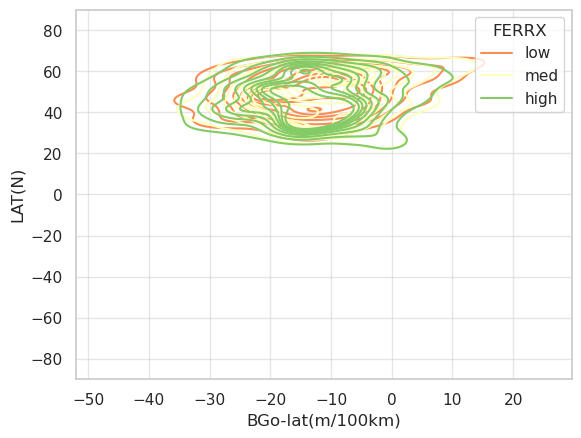

In [35]:
fix_axes(
    sns.kdeplot(
        data=df[df.location == "CONUS"],
        x="BGo-lat(m/100km)",
        y="LAT(N)",
        hue="FERRX",
        palette="RdYlGn",
    )
)

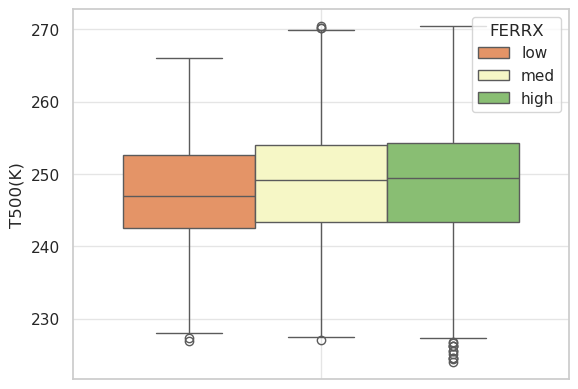

In [36]:
fp = sns.boxplot(
    data=df[df.location == "CONUS"],
    hue="FERRX",
    y="T500(K)",
    palette="RdYlGn",
)
fix_axes(fp)

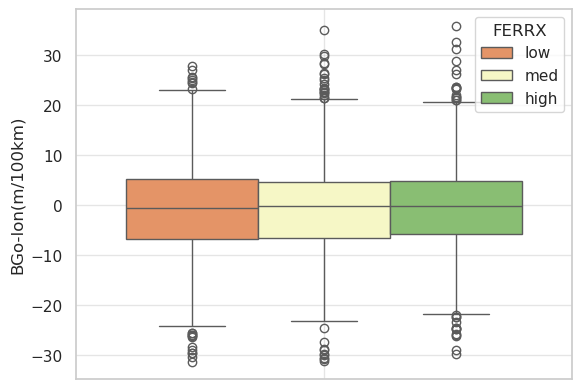

In [37]:
fp = sns.boxplot(
    data=df[df.location == "CONUS"],
    hue="FERRX",
    y="BGo-lon(m/100km)",
    palette="RdYlGn",
)
fix_axes(fp)

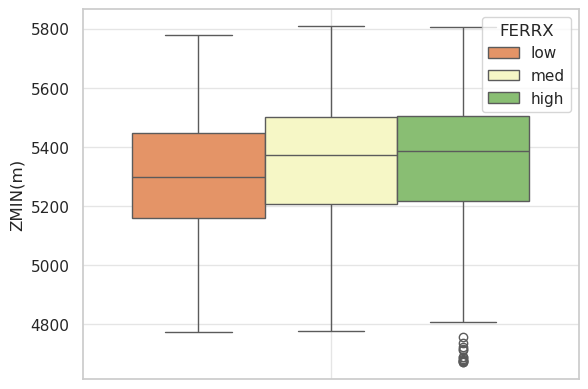

In [38]:
fp = sns.boxplot(
    data=df[df.location == "CONUS"],
    hue="FERRX",
    y="ZMIN(m)",
    palette="RdYlGn",
)
fix_axes(fp)

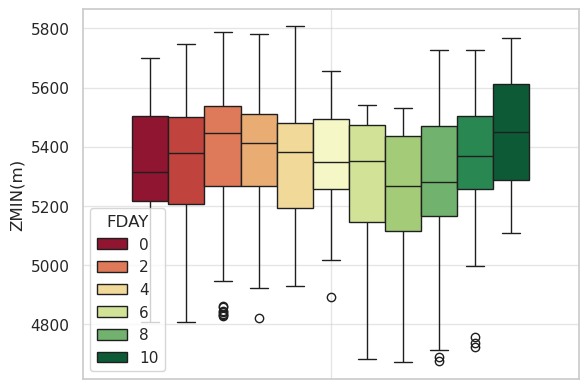

In [39]:
fp = sns.boxplot(
    data=df[(df.location == "CONUS") & (df.FERRX == "high")],
    hue="FDAY",
    y="ZMIN(m)",
    palette="RdYlGn",
)
fix_axes(fp)